# LIGO Gravitational Wave Analysis

Gravitational event GW170817 is a binary neutron merger event. 

Here is a short youtube video for what it is about:

[![Introduction to GW170817](http://img.youtube.com/vi/EtIkOjq0_50/0.jpg)](http://www.youtube.com/watch?v=EtIkOjq0_50 "GW170817")

Its chirp wave which was detected with three gravitational wave detectors (H,L,V), allowing constraining:

* th position on the sky where it originated
* distance
* time of event
* masses of the two progenitors

If you are interested, you can find out more about the science here  https://www.ligo.org/detections/GW170817.php and in one of the many press releases and papers.

We will try to do our own analysis of the chirp signal, with the real data.

The analysis is based on pycbc examples, find out more on the pycbc websites:

* https://pycbc.org/pycbc/latest/html/inference.html
* https://github.com/gwastro/PyCBC-Tutorials/blob/master/tutorial/inference_0_Overview.ipynb
* https://github.com/gwastro/PyCBC-Tutorials/

In [ ]:
!pip install pycbc

In [34]:
!pip3 uninstall -y emcee
!pip3 install emcee==2.2.0

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Found existing installation: emcee 3.1.0
Uninstalling emcee-3.1.0:
  Successfully uninstalled emcee-3.1.0
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Processing /mnt/data/daten/PostDoc2/home/.cache/pip/wheels/1f/bd/4f/dc67dd006d0065d523da42f802d71d4308ad240d7a

In [47]:
import numpy as np
%matplotlib inline

In [1]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd





Processing H1 data
Processing V1 data
Processing L1 data


In [2]:
data

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa7e4eac0a0>,
 'V1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa7e4eacf70>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7fa7e4eaccd0>}

In [17]:
0.118700888243E+10 - m.time

0.029999971389770508

In [56]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, UniformAngle, SinAngle, CosAngle, UniformLog10

static = {'f_lower':25.0,
          'approximant':"TaylorF2",
          'f_final':500,
          'polarization':0,
          'inclination':2.0,
         }

# parameters:
variable = (
    'tc',
    'ra',
    'dec',
    'distance',
    'mchirp',
    'q',
    #'inclination',
    #'polarization',
)

# prior distribution:
# this is for quick results, narrow ranges
prior = JointDistribution(variable, 
    #SinAngle(inclination=None),
    UniformAngle(ra=(3.35, 3.5)),
    CosAngle(dec=(-0.48, -0.3)),
    UniformLog10(mchirp=(1, 2), q=(1, 1.4)),
    Uniform(
        distance=(10, 50),
        tc=(m.time+.027, m.time+0.03),
    ),
)
# this is the general problem (position: RA/Dec unknown)
prior2 = JointDistribution(variable, 
    #SinAngle(inclination=None),
    UniformAngle(ra=None),
    CosAngle(dec=None),
    UniformLog10(mchirp=(1, 10), q=(1, 10)),
    Uniform(
        distance=(10, 100),
        tc=(m.time+.027, m.time+0.03),
    ),
)

from pycbc.transforms import MchirpQToMass1Mass2

# use only some of the data (without Virgo):
partial_data = dict(data)
#del partial_data['V1']

# which model to fit to the data
model = models.MarginalizedPhaseGaussianNoise(
    variable,
    partial_data,
    low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
    high_frequency_cutoff = {'H1':500, 'L1':500, 'V1':500},
    psds = psds,
    static_params = static,
    prior = prior,
    waveform_transforms = [MchirpQToMass1Mass2()]
)



In [75]:
#from pycbc.inference.sampler.emcee import EmceeEnsembleSampler
#smpl = EmceeEnsembleSampler(model, 200, nprocesses=8)
#_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!


In [76]:
#smpl.clear_samples()

In [77]:
# Note it may take ~1-3 minutes for this to run
#smpl.run_mcmc(200)

In [78]:
#smpl.sampling_params

In [79]:
#smpl.samples

In [80]:
#flat_samples = np.transpose([smpl.samples[k].flatten() for k in smpl.sampling_params])
#flat_samples.shape

In [81]:
#import corner
#corner.corner(flat_samples[10000:,:], labels=smpl.sampling_params);

In [82]:
#from pycbc.inference.sampler import DynestySampler
#sampler = DynestySampler(model, nlive=400)
#sampler.run()

In [57]:
from pycbc.inference.sampler import UltranestSampler

In [67]:
sampler = UltranestSampler(
    model, log_dir='LIGOcut6', 
    frac_remain=0.5,
    #min_num_live_points=400
)

In [69]:
sampler._sampler.stepsampler = None

In [70]:
# if you want to use MCMC for the LRPS, which gives a constant efficiency

#import ultranest.stepsampler
#sampler._sampler.stepsampler = ultranest.stepsampler.CubeSliceSampler(nsteps=8)

In [71]:
sampler.run()

[ultranest] Widening roots to 400 live points (have 400 already) ...


[ultranest] Explored until L=-2e+05  ..-206840.80 [-206843.3284..-206843.3266]*| it/evals=11339/830543 eff=1.3824% N=400 
[ultranest] Likelihood function evaluations: 830543
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Reached maximum number of improvement loops.
[ultranest] done iterating.

logZ = -206870.152 +- 0.495
  single instance: logZ = -206870.152 +- 0.254
  bootstrapped   : logZ = -206870.132 +- 0.285
  tail           : logZ = +- 0.405
insert order U test : converged: True correlation: inf iterations

    tc                  1187008882.42889 +- 0.00043
    ra                  3.417 +- 0.019
    dec                 -0.352 +- 0.029
    distance            19.80 +- 0.69
    mchirp              1.197522 +- 0.000051
    q                   1.197 +- 0.063


In [72]:
sampler.samples

{'tc': array([1.18700888e+09, 1.18700888e+09, 1.18700888e+09, ...,
        1.18700888e+09, 1.18700888e+09, 1.18700888e+09]),
 'ra': array([3.41978869, 3.43912098, 3.41725205, ..., 3.42887199, 3.3872484 ,
        3.39433908]),
 'dec': array([-0.37233948, -0.37936121, -0.35506555, ..., -0.34928831,
        -0.32375145, -0.33022813]),
 'distance': array([19.65203942, 20.98632078, 19.47270944, ..., 19.71801802,
        19.586851  , 18.76023911]),
 'mchirp': array([1.19748953, 1.19743456, 1.19753607, ..., 1.19758356, 1.197509  ,
        1.19748855]),
 'q': array([1.20575373, 1.27520027, 1.18157495, ..., 1.11690756, 1.24028136,
        1.25668514]),
 'loglikelihood': array([-206843.66909107, -206844.95721771, -206841.28252703, ...,
        -206842.96750416, -206843.14420791, -206843.08336851])}

In [73]:
flat_samples = np.transpose([sampler.samples[k].flatten() for k in sampler.sampling_params])
flat_samples.shape

(11740, 6)

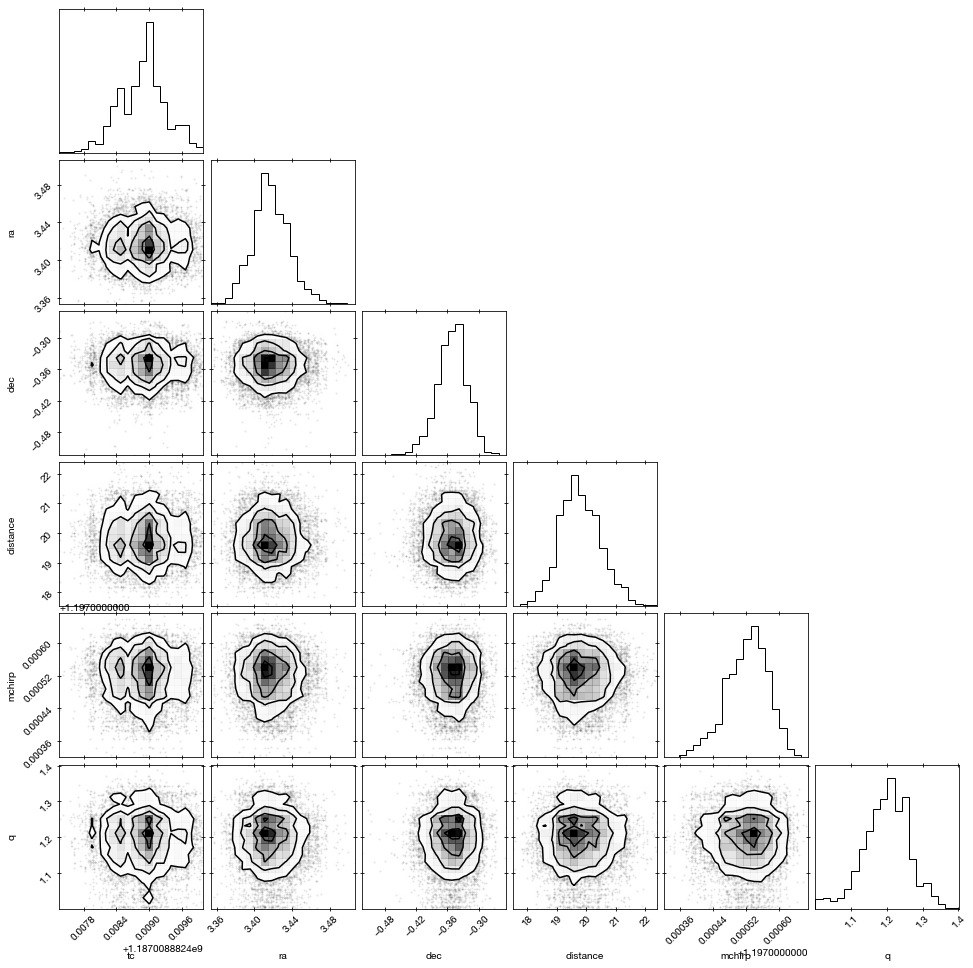

In [74]:
import corner
corner.corner(flat_samples, labels=sampler.sampling_params);

In [55]:
flat_samples[:,0].min() - m.time

0.027405977249145508

## Exercise 1: MCMC

(no points here because this is an outline how to approach the big homework below)

* Run MCMC for a number of iterations.
* Plot the posterior distribution (with getdist or corner or arviz).
* You constrained the position of this event on the sky (RA, Dec). Compute error bars. Show a picture of that part of the sky with the error ellipse 
  * (You can use https://github.com/cds-astro/ipyaladin or show a image or include a html/script via %%html, as below).
* use the methods learned earlier to investigate whether the chain has converged


In [11]:
%%html

<!-- This example was taken from https://aladin.u-strasbg.fr/AladinLite/doc/API/examples/   -->

<link rel='stylesheet' href='https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.css' />
<script type='text/javascript' src='https://code.jquery.com/jquery-1.9.1.min.js' charset='utf-8'></script>

<div id='aladin-lite-div' style='width: 500px;height: 500px;'></div>
<script type='text/javascript' src='https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.js' charset='utf-8'></script>

<script>

// position on the sky:
ra = 56.87115
dec = 24.10514
target = '56.87115, 24.10514'

var a = A.aladin('#aladin-lite-div', {
    target: target,
    survey: 'P/DSS2/color', 
    zoom: 2, showReticle: false});
var cat = A.catalog({name: 'Some markers', sourceSize: 18});
a.addCatalog(cat);
cat.addSources([A.marker(ra, dec, {popupTitle: 'Alcyone', popupDesc: '<em>Bmag:</em> 2.806<br/><em>Spectral type:</em> B7III<br/>More info <a target="_blank" href="https://simbad.u-strasbg.fr/simbad/sim-id?Ident=NAME%20ALCYONE&submit=submit">in Simbad</a>'})]);
</script>


## Exercise 2: Nested Sampling

* Run the UltranestSampler `UltranestSampler(model, log_dir='my-results-directory', stepsampling=True)`. If it is slow, run with MPI (`mpiexec -np 8 python3 myscript.py`).
* Plot the posterior distributions (with getdist or corner or arviz).
* Compute the information gain for each parameter compared to the prior.
* vary the data sets, by only using one or two of the LIGO/VIRGO detectors: What constraints can be obtained then?

## Big Homework (200 points): Compare two sampling approaches

Select a inference problem with 6-20 parameters. You can either 
a) Use the LIGO problem above or
b) choose your own problem. In that case, use a simplified version.

Implement inference with **at least two of the three** techniques (Importance Sampling, MCMC, Nested Sampling) and run them until convergence. You can use your own implementations, but include at least one modern sampler (for example: stan, ultranest, dynesty, multinest, zeus, emcee, autoemcee, snowline).

* Compare their performance qualitatively: ease of use, correctness of the result (consistency among the samplers or with published result)
* Compare their performance quantitatively: number of effective samples per wall-clock time
* Make at least one variation of a sampler tuning parameter (for example the number of walkers).
